# Inspect the single-lineage model run on the prostate data (009)

 Model attributes:

- sgRNA | gene varying intercept
- RNA and CN varying effects per gene
- correlation between gene varying effects modeled using the multivariate normal and Cholesky decomposition (non-centered parameterization)
- target gene mutation variable and cancer gene comutation variable.
- varying intercept and slope for copy number for chromosome nested with in cell line

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from math import ceil
from time import time

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Markdown, display

In [3]:
from speclet.analysis.arviz_analysis import extract_coords_param_names
from speclet.bayesian_models.lineage_hierarchical_nb import LineageHierNegBinomModel
from speclet.data_processing.common import head_tail
from speclet.io import modeling_data_dir, models_dir
from speclet.managers.data_managers import CrisprScreenDataManager, broad_only
from speclet.plot import set_speclet_theme
from speclet.project_configuration import arviz_config

In [4]:
# Notebook execution timer.
notebook_tic = time()

# Plotting setup.
set_speclet_theme()
%config InlineBackend.figure_format = "retina"
arviz_config()

## Data

In [5]:
LINEAGE = "prostate"

In [6]:
saved_model_dir = models_dir() / f"hnb-single-lineage-{LINEAGE}-009_PYMC_NUMPYRO"

In [7]:
with open(saved_model_dir / "description.txt") as f:
    model_description = "".join(list(f))

print(model_description)

config. name: 'hnb-single-lineage-prostate-009'
model name: 'LineageHierNegBinomModel'
model version: '0.0.3'
model description: A hierarchical negative binomial generalized linear model for one lineage.
fit method: 'PYMC_NUMPYRO'

--------------------------------------------------------------------------------

CONFIGURATION

{
    "name": "hnb-single-lineage-prostate-009",
    "description": " Single lineage hierarchical negative binomial model for prostate data from the Broad.\nVarying effects for each chromosome of each cell line has been nested under the existing varying effects for cell line. ",
    "active": true,
    "model": "LINEAGE_HIERARCHICAL_NB",
    "data_file": "modeling_data/lineage-modeling-data/depmap-modeling-data_prostate.csv",
    "model_kwargs": {
        "lineage": "prostate"
    },
    "sampling_kwargs": {
        "pymc_mcmc": null,
        "pymc_advi": null,
        "pymc_numpyro": {
            "draws": 1000,
            "tune": 2000,
            "chains": 4,

### Load posterior summary

In [8]:
prostate_post_summary = pd.read_csv(saved_model_dir / "posterior-summary.csv").assign(
    var_name=lambda d: [x.split("[")[0] for x in d["parameter"]]
)
prostate_post_summary.head()

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
0   mu_mu_a  0.068  0.022     0.036      0.101      0.001    0.000    1474.0   
1      mu_b  0.004  0.001     0.003      0.005      0.000    0.000    3432.0   
2   mu_mu_m -0.252  0.063    -0.345     -0.151      0.001    0.001    2777.0   
3   sigma_a  0.211  0.001     0.210      0.213      0.000    0.000    1330.0   
4   sigma_k  0.033  0.003     0.028      0.037      0.000    0.000    1031.0   

   ess_tail  r_hat var_name  
0    1846.0    1.0  mu_mu_a  
1    2961.0    1.0     mu_b  
2    2899.0    1.0  mu_mu_m  
3    2143.0    1.0  sigma_a  
4    1788.0    1.0  sigma_k

### Load trace object

In [9]:
trace_file = saved_model_dir / "posterior.netcdf"
assert trace_file.exists()
trace = az.from_netcdf(trace_file)

### Prostate data

In [10]:
prostate_dm = CrisprScreenDataManager(
    modeling_data_dir()
    / "lineage-modeling-data"
    / f"depmap-modeling-data_{LINEAGE}.csv",
    transformations=[broad_only],
)

In [11]:
prostate_data = prostate_dm.get_data(read_kwargs={"low_memory": False})
prostate_data.head()

sgrna                 replicate_id       lfc p_dna_batch  \
0  AAAGCCCAGGAGTATGGGAG  Vcap-304Cas9_RepA_p4_batch3  0.246450           3   
1  AAATCAGAGAAACCTGAACG  Vcap-304Cas9_RepA_p4_batch3  0.626518           3   
2  AACGTCTTTGAAGAAAGCTG  Vcap-304Cas9_RepA_p4_batch3  0.165114           3   
3  AACGTCTTTGAAGGAAGCTG  Vcap-304Cas9_RepA_p4_batch3 -0.094688           3   
4  AAGAGGTTCCAGACTACTTA  Vcap-304Cas9_RepA_p4_batch3  0.294496           3   

   genome_alignment hugo_symbol screen  multiple_hits_on_gene  \
0  chr2_130522105_-       CFC1B  broad                   True   
1  chr11_89916950_-    TRIM49D1  broad                   True   
2   chr5_71055421_-      GTF2H2  broad                   True   
3   chr5_69572480_+     GTF2H2C  broad                   True   
4  chrX_155898173_+       VAMP7  broad                   True   

  sgrna_target_chr  sgrna_target_pos  ... any_deleterious  any_tcga_hotspot  \
0                2         130522105  ...             NaN               NaN   
1               11          89916950  ...             NaN               NaN   
2                5          71055421  ...             NaN               NaN   
3                5          69572480  ...             NaN               NaN   
4                X         155898173  ...             NaN               NaN   

   any_cosmic_hotspot  is_mutated  copy_number   lineage  \
0                 NaN       False     0.999455  prostate   
1                 NaN       False     1.281907  prostate   
2                 NaN       False     0.616885  prostate   
3                 NaN       False     0.616885  prostate   
4                 NaN       False     0.615935  prostate   

           lineage_subtype primary_or_metastasis  is_male   age  
0  prostate_adenocarcinoma            metastasis     True  59.0  
1  prostate_adenocarcinoma            metastasis     True  59.0  
2  prostate_adenocarcinoma            metastasis     True  59.0  
3  prostate_adenocarcinoma            metastasis     True  59.0  
4  prostate_adenocarcinoma            metastasis     True  59.0  

[5 rows x 25 columns]

### Single lineage model

In [12]:
prostate_model = LineageHierNegBinomModel(lineage=LINEAGE)

In [13]:
valid_prostate_data = prostate_model.data_processing_pipeline(prostate_data.copy())
prostate_mdl_data = prostate_model.make_data_structure(valid_prostate_data)

[INFO] 2022-08-08 15:36:51 [(lineage_hierarchical_nb.py:data_processing_pipeline:317] Processing data for modeling.
[INFO] 2022-08-08 15:36:51 [(lineage_hierarchical_nb.py:data_processing_pipeline:318] LFC limits: (-5.0, 5.0)
[WARNING] 2022-08-08 15:38:09 [(lineage_hierarchical_nb.py:data_processing_pipeline:376] number of data points dropped: 2
[INFO] 2022-08-08 15:38:09 [(lineage_hierarchical_nb.py:target_gene_is_mutated_vector:597] number of genes mutated in all cells lines: 0
[DEBUG] 2022-08-08 15:38:09 [(lineage_hierarchical_nb.py:target_gene_is_mutated_vector:600] Genes always mutated: 
[DEBUG] 2022-08-08 15:38:10 [(cancer_gene_mutation_matrix.py:_trim_cancer_genes:68] all_mut: {}
[INFO] 2022-08-08 15:38:10 [(cancer_gene_mutation_matrix.py:_trim_cancer_genes:77] Dropping 8 cancer genes.
[DEBUG] 2022-08-08 15:38:10 [(cancer_gene_mutation_matrix.py:_trim_cancer_genes:79] Dropped cancer genes: ['AR', 'AXIN1', 'FOXA1', 'KLF6', 'NCOR2', 'PTEN', 'SALL4', 'SPOP']


## Analysis

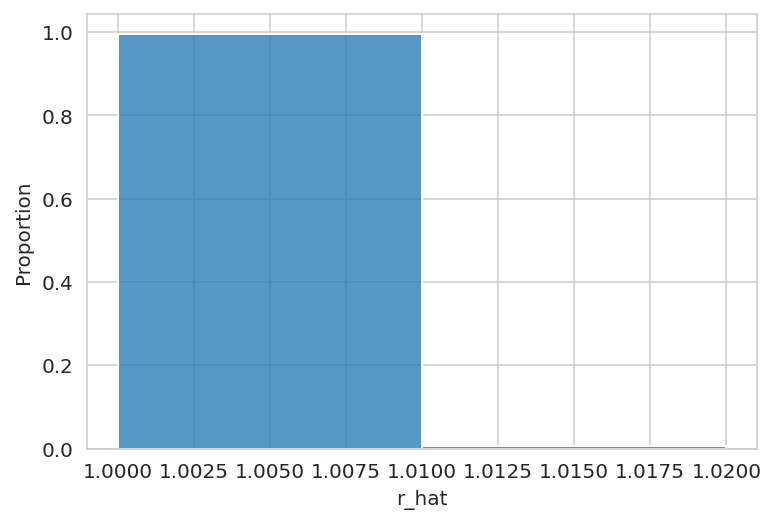

In [14]:
sns.histplot(x=prostate_post_summary["r_hat"], binwidth=0.01, stat="proportion");

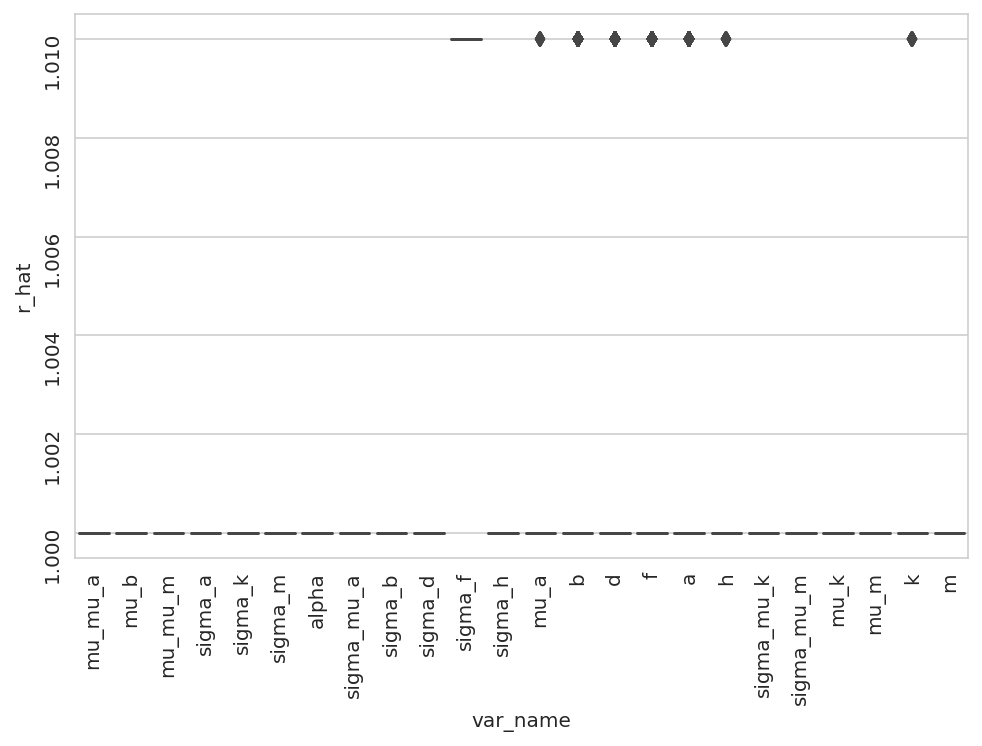

In [15]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=prostate_post_summary, x="var_name", y="r_hat", ax=ax)
ax.tick_params(rotation=90)
plt.show()

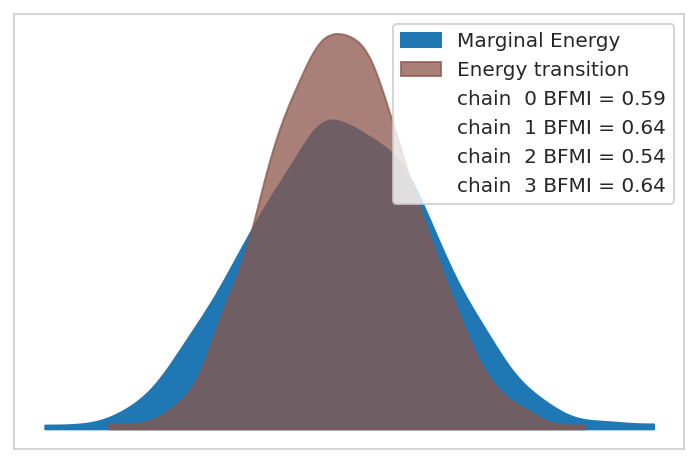

In [16]:
az.plot_energy(trace);

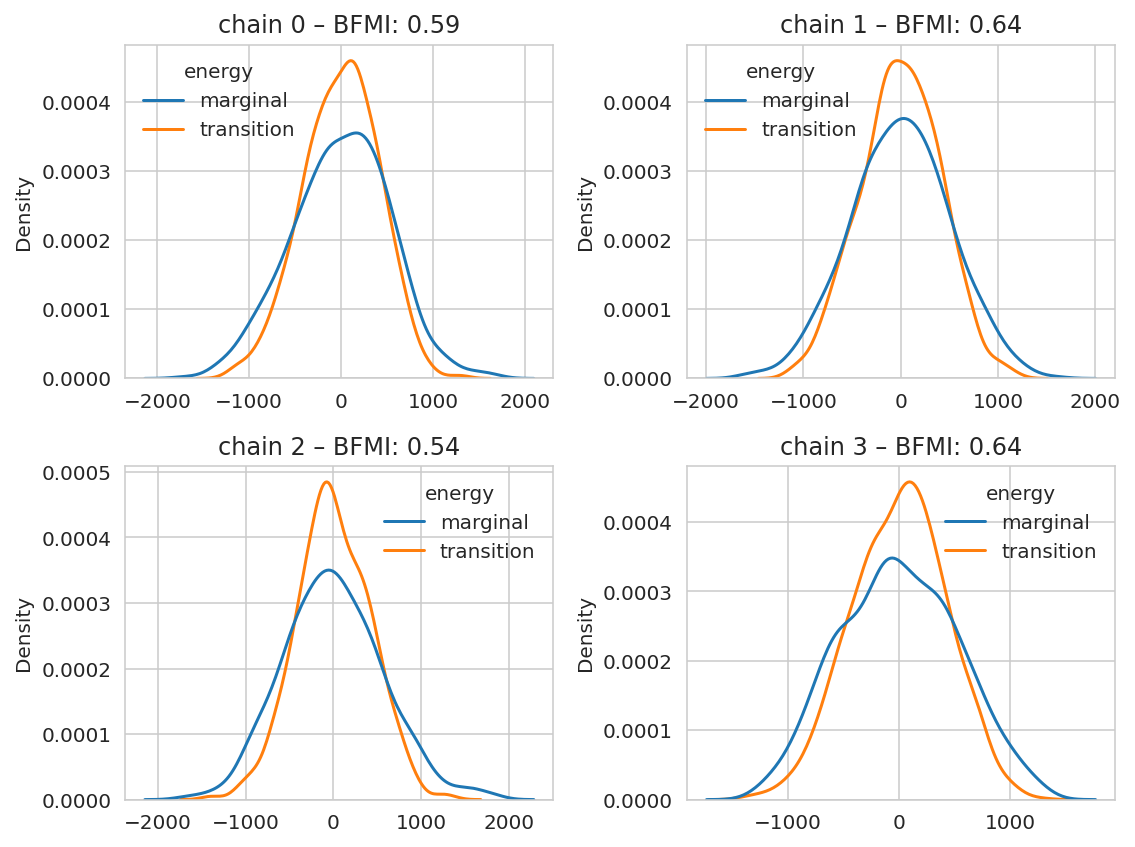

In [17]:
energy = trace.sample_stats.energy.values
marginal_e = pd.DataFrame((energy - energy.mean(axis=1)[:, None]).T).assign(
    energy="marginal"
)
transition_e = pd.DataFrame((energy[:, :-1] - energy[:, 1:]).T).assign(
    energy="transition"
)
energy_df = pd.concat([marginal_e, transition_e]).reset_index(drop=True)
bfmi = az.bfmi(trace)

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
for i, ax in enumerate(axes.flatten()):
    sns.kdeplot(data=energy_df, x=i, hue="energy", ax=ax)
    ax.set_title(f"chain {i} – BFMI: {bfmi[i]:0.2f}")
    ax.set_xlabel(None)
    xmin, _ = ax.get_xlim()
    _, ymax = ax.get_ylim()
    ax.get_legend().set_frame_on(False)

fig.tight_layout()
plt.show()

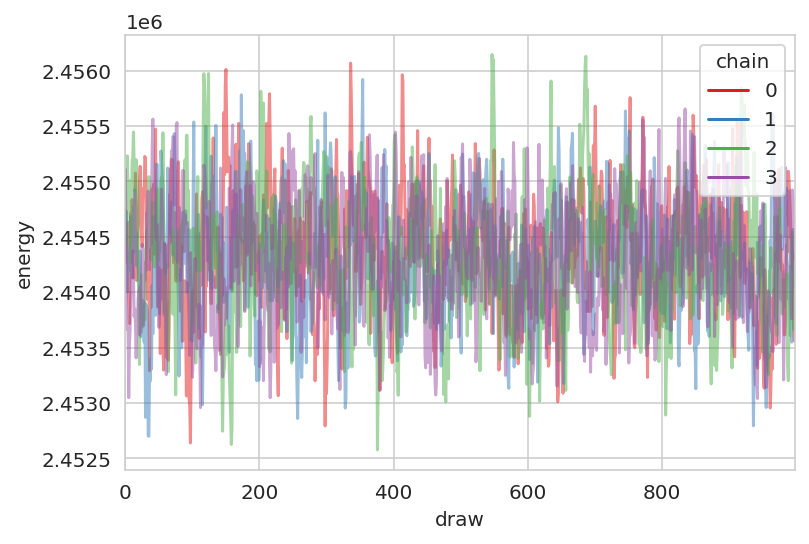

In [18]:
hmc_energy = (
    trace.sample_stats.get("energy")
    .to_dataframe()
    .reset_index(drop=False)
    .astype({"chain": "category"})
)
ax = sns.lineplot(
    data=hmc_energy, x="draw", y="energy", hue="chain", palette="Set1", alpha=0.5
)
ax.set_xlim(0, hmc_energy["draw"].max())
plt.show()

In [19]:
stats = ["step_size", "n_steps", "tree_depth", "acceptance_rate", "energy"]
trace.sample_stats.get(stats).to_dataframe().groupby("chain").mean()

step_size  n_steps  tree_depth  acceptance_rate        energy
chain                                                               
0       0.008994    511.0         9.0         0.975439  2.454373e+06
1       0.009703    511.0         9.0         0.974011  2.454306e+06
2       0.008403    511.0         9.0         0.979780  2.454294e+06
3       0.008710    511.0         9.0         0.974836  2.454288e+06

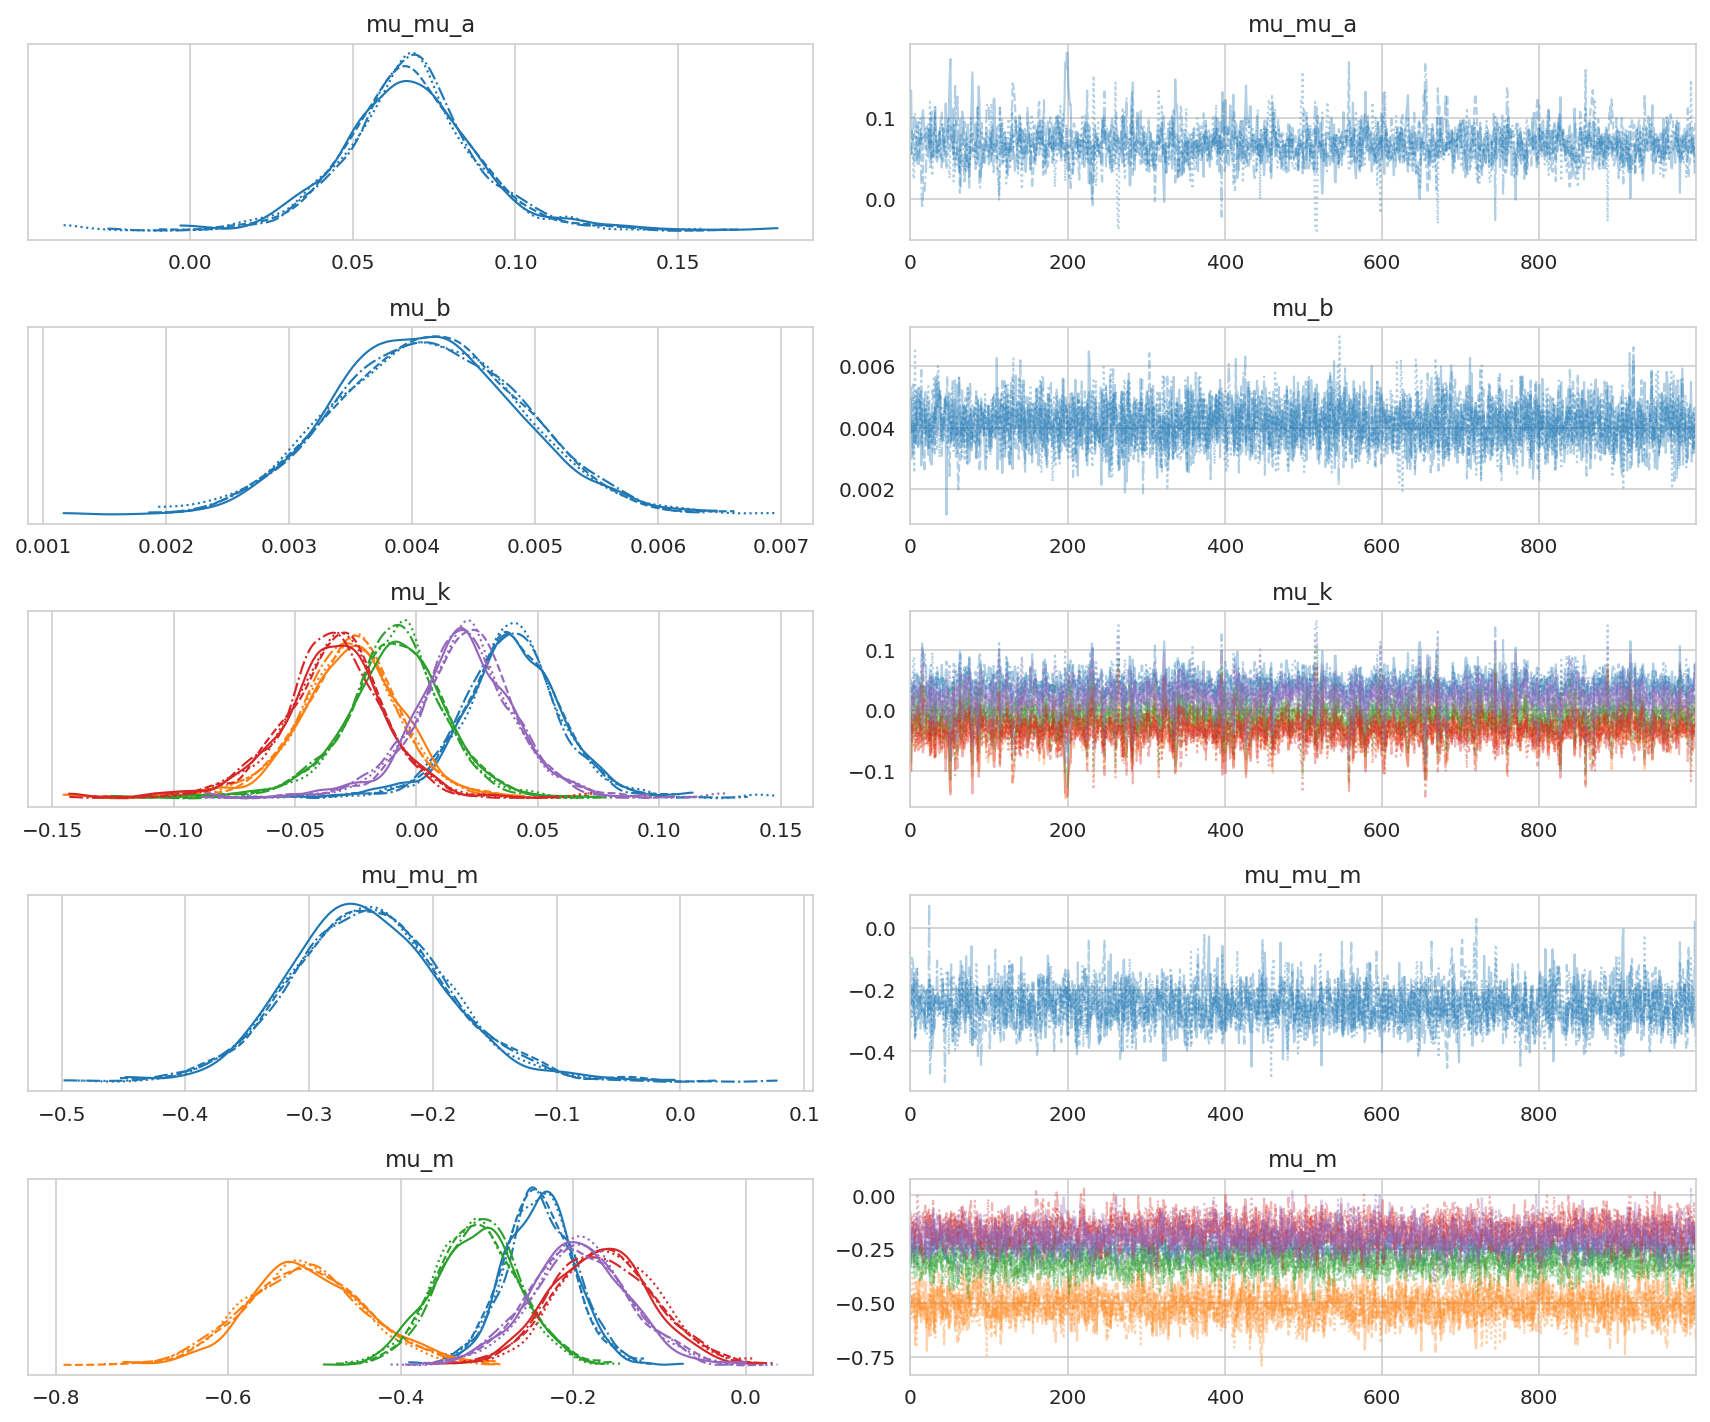

In [20]:
az.plot_trace(
    trace, var_names=["mu_mu_a", "mu_b", "mu_k", "mu_mu_m", "mu_m"], compact=True
)
plt.tight_layout()
plt.show()

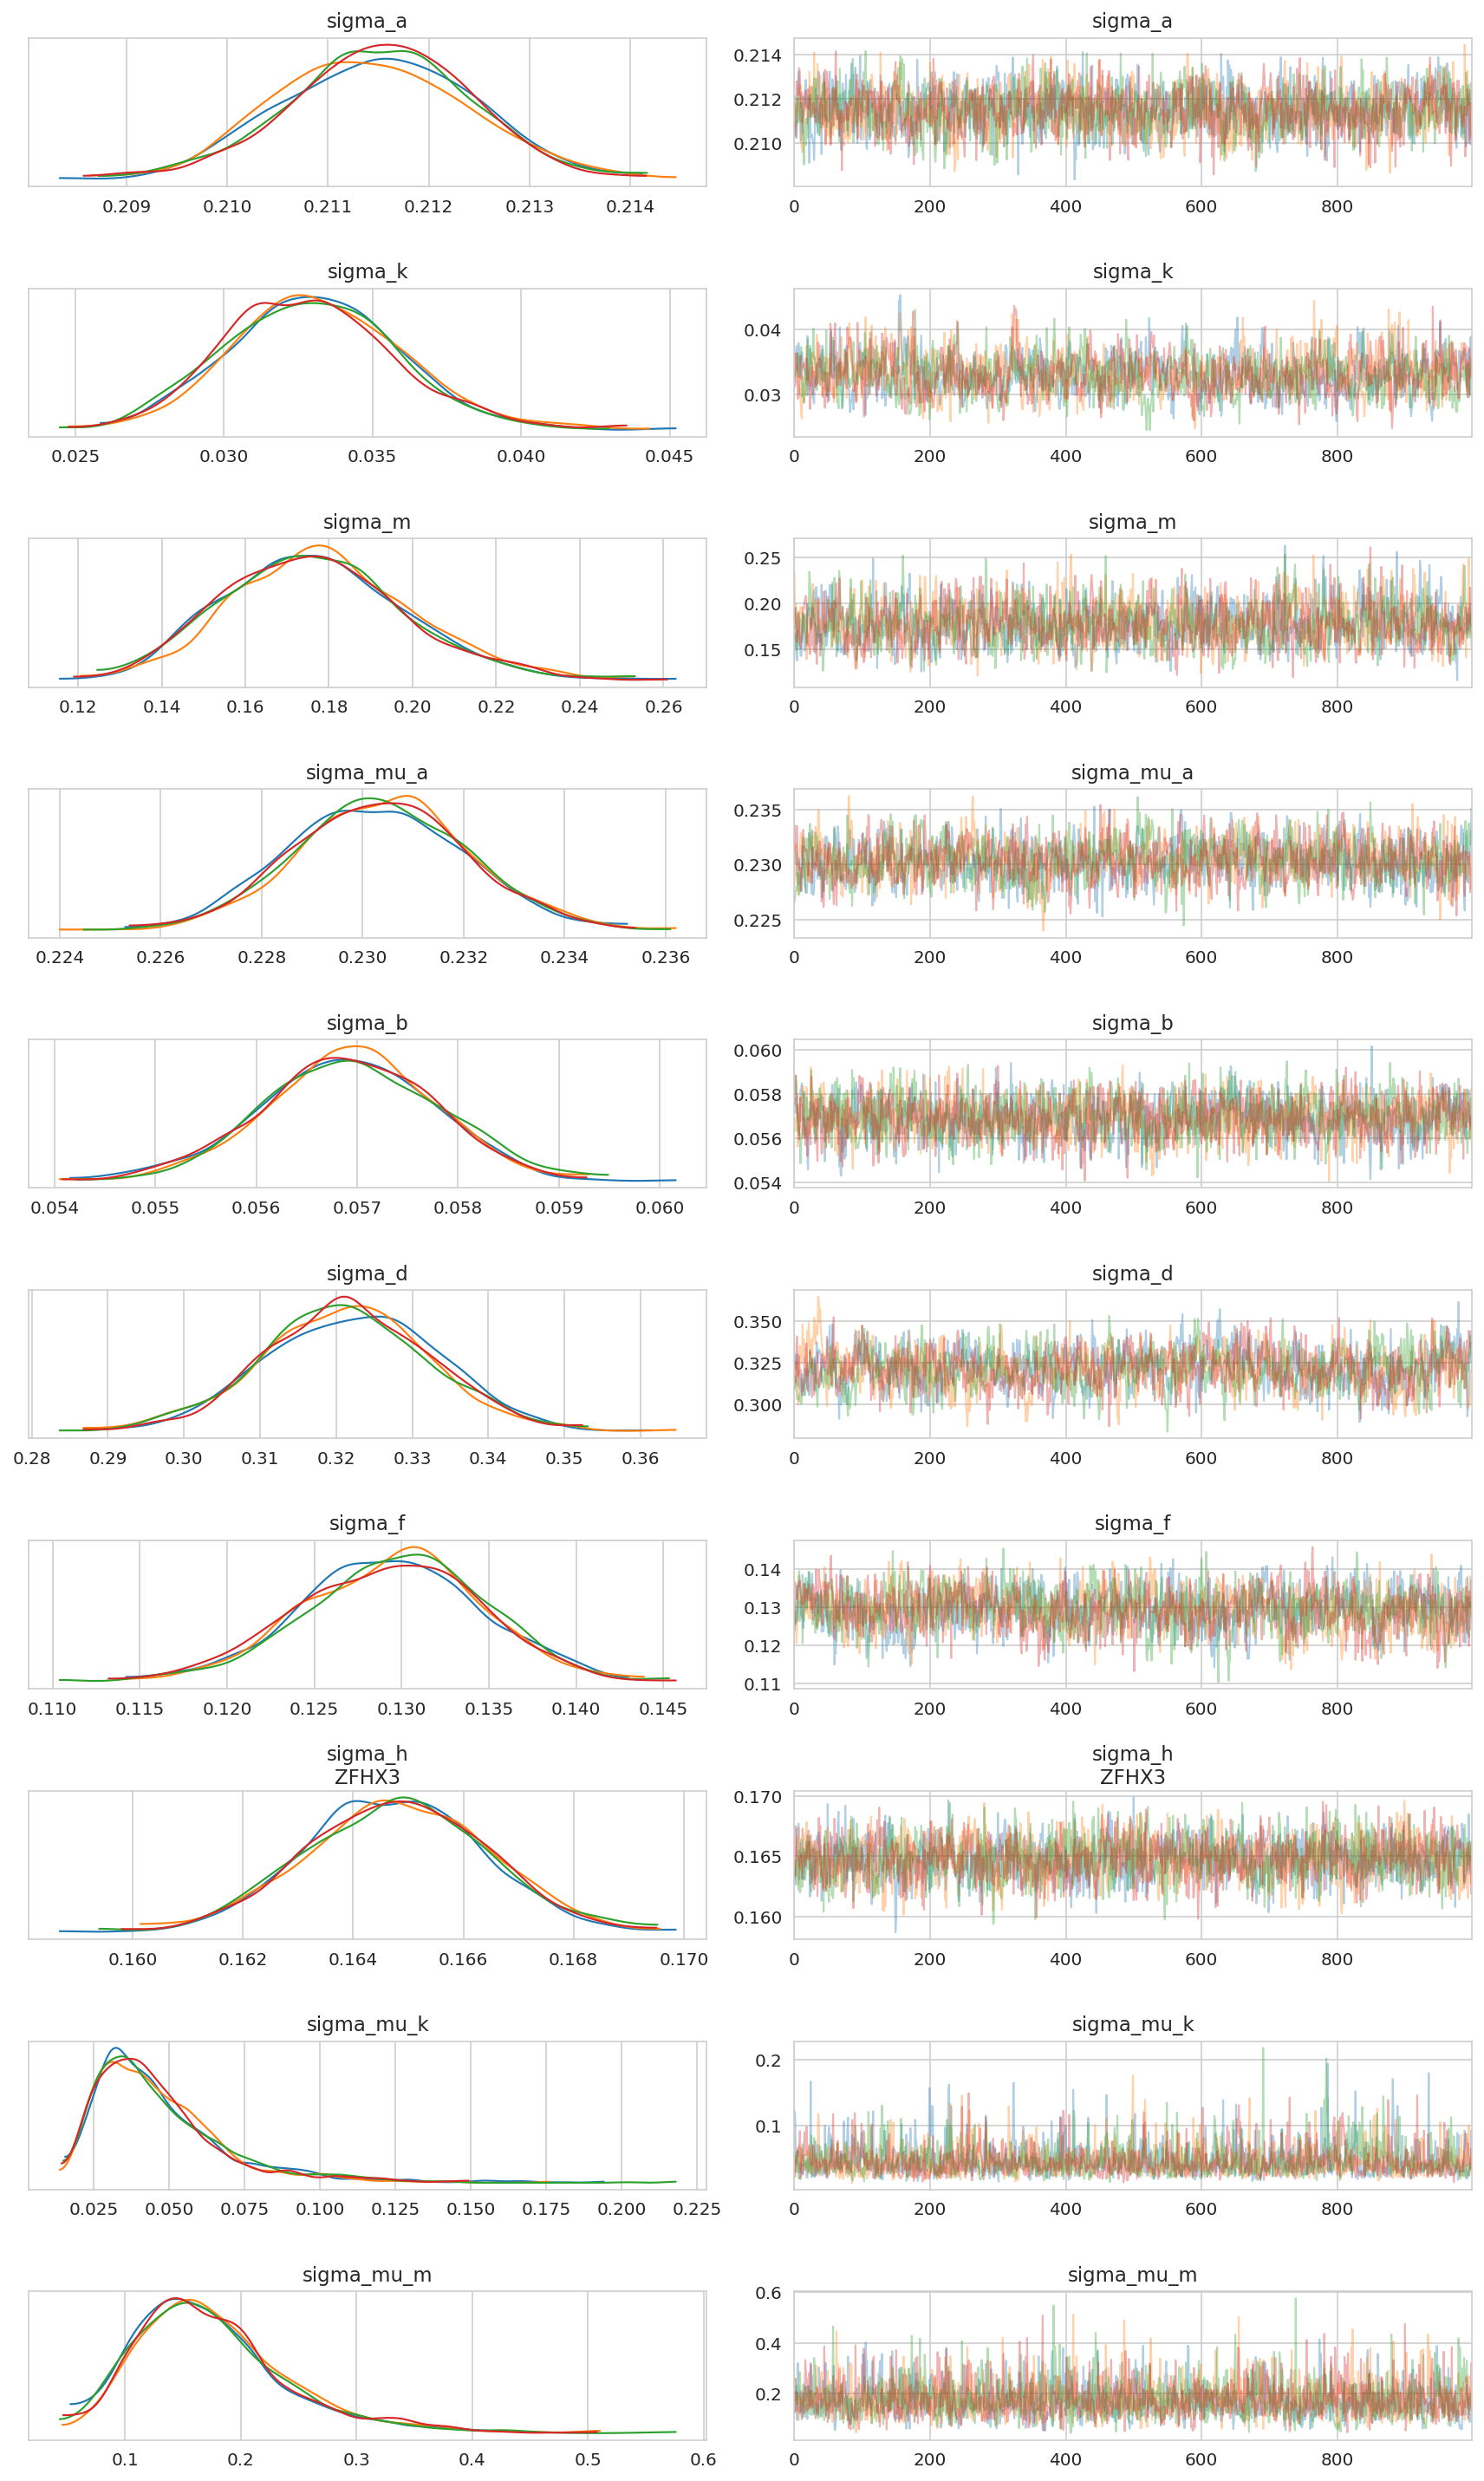

In [21]:
az.plot_trace(trace, var_names=["^sigma_*"], filter_vars="regex", compact=False)
plt.tight_layout()

In [22]:
sigmas = ["sigma_mu_a", "sigma_b", "sigma_d", "sigma_f", "sigma_k"]
trace.posterior.get(sigmas).mean(dim="draw").to_dataframe()

sigma_mu_a   sigma_b   sigma_d   sigma_f   sigma_k
chain                                                    
0        0.230241  0.056882  0.322394  0.129311  0.033118
1        0.230464  0.056938  0.321099  0.129494  0.033278
2        0.230367  0.056981  0.321000  0.129721  0.032857
3        0.230338  0.056893  0.321615  0.129138  0.032885

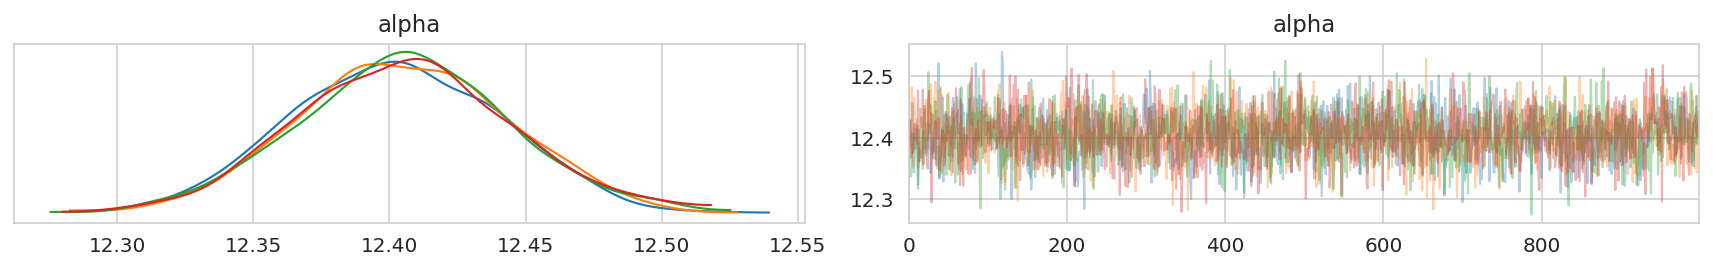

In [23]:
az.plot_trace(trace, var_names=["alpha"], compact=False)
plt.tight_layout()

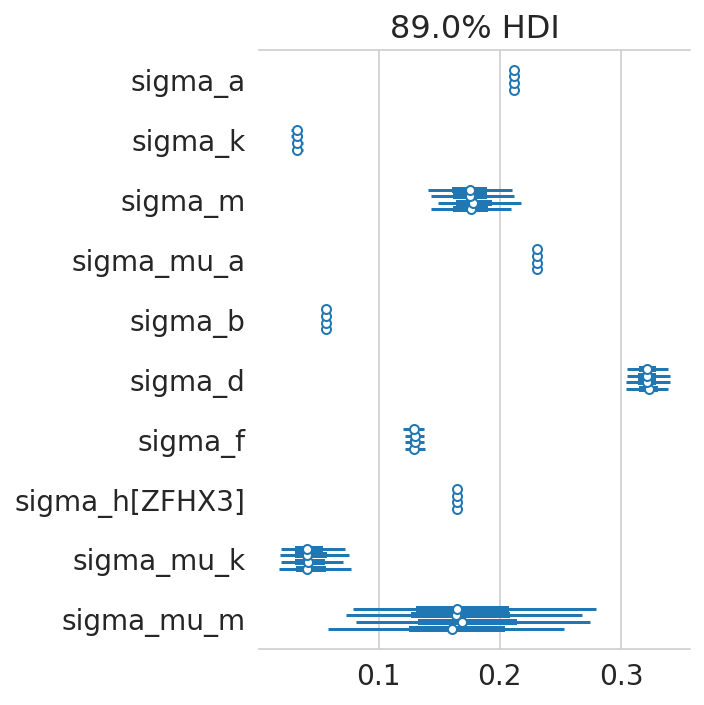

In [24]:
az.plot_forest(
    trace, var_names=["^sigma_*"], filter_vars="regex", combined=False, figsize=(5, 5)
)
plt.tight_layout()

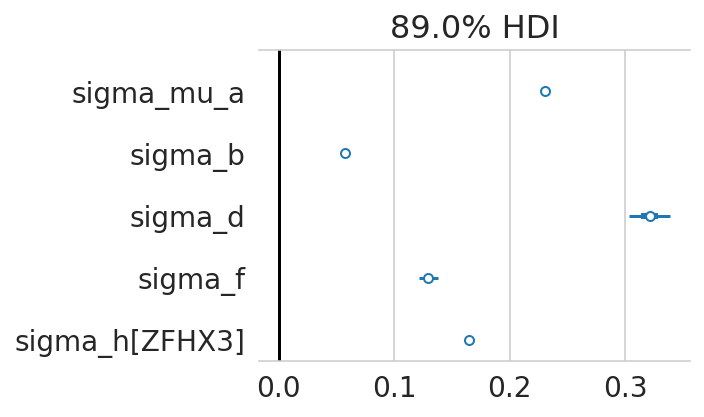

In [25]:
axes = az.plot_forest(
    trace,
    var_names=["sigma_mu_a", "sigma_b", "sigma_d", "sigma_f", "sigma_h"],
    figsize=(5, 3),
    combined=True,
)
axes[0].axvline(0, color="k", zorder=1)
plt.tight_layout()
plt.show()

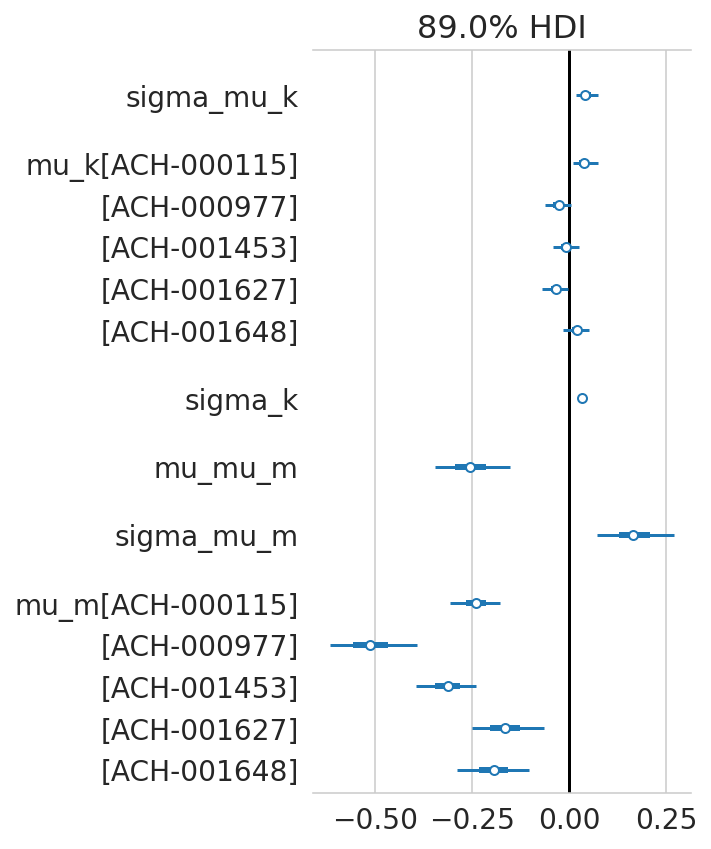

In [26]:
axes = az.plot_forest(
    trace,
    var_names=["sigma_mu_k", "mu_k", "sigma_k", "mu_mu_m", "sigma_mu_m", "mu_m"],
    figsize=(5, 6),
    combined=True,
)
axes[0].axvline(0, color="k", zorder=1)
plt.tight_layout()
plt.show()

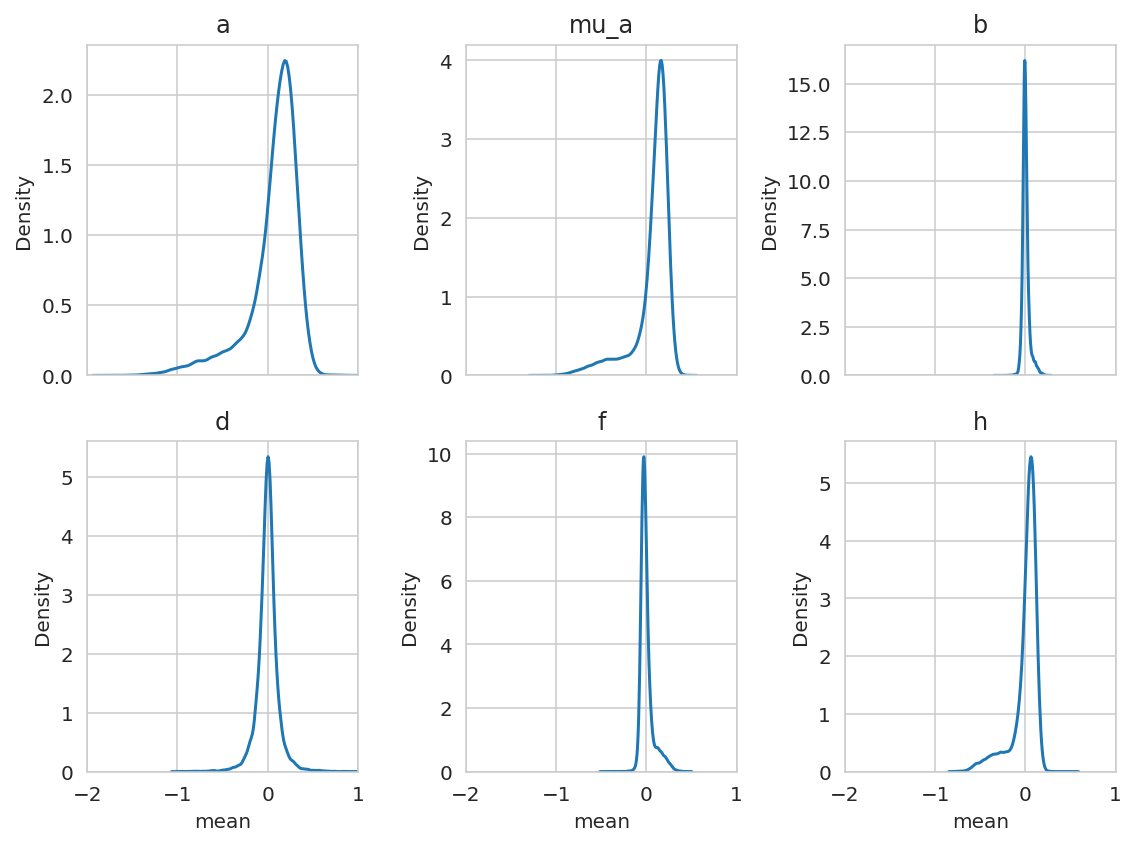

In [27]:
var_names = ["a", "mu_a", "b", "d", "f", "h"]
_, axes = plt.subplots(2, 3, figsize=(8, 6), sharex=True)
for ax, var_name in zip(axes.flatten(), var_names):
    x = prostate_post_summary.query(f"var_name == '{var_name}'")["mean"]
    sns.kdeplot(x=x, ax=ax)
    ax.set_title(var_name)
    ax.set_xlim(-2, 1)

plt.tight_layout()
plt.show()

In [28]:
sgrna_to_gene_map = (
    prostate_data.copy()[["hugo_symbol", "sgrna"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

In [29]:
for v in ["mu_a", "b", "d", "f", "h", "k", "m"]:
    display(Markdown(f"variable: **{v}**"))
    top = (
        prostate_post_summary.query(f"var_name == '{v}'")
        .sort_values("mean")
        .reset_index(drop=True)
        .pipe(head_tail, 5)
    )
    display(top)

variable: **mu_a**

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
0         mu_a[KIF11] -1.211  0.103    -1.366     -1.044      0.002    0.001   
1         mu_a[HSPE1] -1.032  0.096    -1.191     -0.882      0.002    0.001   
2         mu_a[SPC24] -1.019  0.102    -1.185     -0.862      0.002    0.001   
3           mu_a[RAN] -1.003  0.097    -1.150     -0.843      0.002    0.001   
4          mu_a[DUX4] -0.998  0.096    -1.156     -0.847      0.002    0.001   
18114   mu_a[PRAMEF4]  0.402  0.094     0.244      0.542      0.002    0.001   
18115  mu_a[ARHGAP44]  0.403  0.094     0.264      0.564      0.002    0.001   
18116  mu_a[HLA-DQB1]  0.413  0.105     0.250      0.585      0.002    0.001   
18117      mu_a[TP53]  0.460  0.094     0.317      0.610      0.002    0.001   
18118      mu_a[CCNF]  0.468  0.116     0.277      0.646      0.002    0.001   

       ess_bulk  ess_tail  r_hat var_name  
0        3081.0    3146.0    1.0     mu_a  
1        2615.0    2424.0    1.0     mu_a  
2        2819.0    2917.0    1.0     mu_a  
3        2907.0    2986.0    1.0     mu_a  
4        2752.0    3114.0    1.0     mu_a  
18114    3040.0    2942.0    1.0     mu_a  
18115    2764.0    2970.0    1.0     mu_a  
18116    3195.0    2995.0    1.0     mu_a  
18117    3008.0    3057.0    1.0     mu_a  
18118    3081.0    3276.0    1.0     mu_a

variable: **b**

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
0        b[EP300] -0.334  0.043    -0.395     -0.260      0.001      0.0   
1         b[TP63] -0.186  0.040    -0.254     -0.126      0.000      0.0   
2        b[TADA1] -0.180  0.041    -0.243     -0.115      0.000      0.0   
3        b[STAG2] -0.175  0.039    -0.234     -0.112      0.000      0.0   
4       b[HOXB13] -0.170  0.044    -0.240     -0.099      0.001      0.0   
18114  b[NDUFB11]  0.226  0.042     0.161      0.294      0.000      0.0   
18115  b[ATP6V1F]  0.228  0.043     0.164      0.301      0.000      0.0   
18116      b[GPI]  0.238  0.044     0.167      0.311      0.001      0.0   
18117    b[NARS2]  0.245  0.041     0.182      0.312      0.000      0.0   
18118    b[AIFM1]  0.272  0.043     0.204      0.342      0.000      0.0   

       ess_bulk  ess_tail  r_hat var_name  
0        6200.0    2790.0   1.00        b  
1        8945.0    2779.0   1.00        b  
2        7273.0    3033.0   1.00        b  
3        6958.0    2888.0   1.00        b  
4        7460.0    2962.0   1.01        b  
18114    7899.0    3028.0   1.00        b  
18115    9207.0    2798.0   1.01        b  
18116    7846.0    3156.0   1.00        b  
18117    8483.0    2982.0   1.00        b  
18118    7843.0    2445.0   1.00        b

variable: **d**

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
0       d[UBE2N] -1.014  0.239    -1.370     -0.613      0.003    0.002   
1       d[CNOT1] -0.938  0.270    -1.357     -0.510      0.003    0.003   
2       d[KMT2D] -0.896  0.245    -1.298     -0.520      0.003    0.002   
3       d[EARS2] -0.894  0.273    -1.329     -0.483      0.003    0.003   
4        d[KLF5] -0.857  0.234    -1.221     -0.474      0.003    0.002   
18114  d[MRPL39]  0.832  0.267     0.424      1.263      0.003    0.003   
18115   d[TOP2A]  0.838  0.244     0.478      1.262      0.003    0.002   
18116    d[PWP2]  0.849  0.237     0.444      1.210      0.003    0.002   
18117   d[ITGB1]  0.883  0.249     0.507      1.284      0.003    0.002   
18118   d[DMAC1]  1.059  0.252     0.665      1.459      0.003    0.002   

       ess_bulk  ess_tail  r_hat var_name  
0        6817.0    2824.0    1.0        d  
1        6855.0    2881.0    1.0        d  
2        5900.0    2701.0    1.0        d  
3        6316.0    3080.0    1.0        d  
4        5845.0    3357.0    1.0        d  
18114    6060.0    3295.0    1.0        d  
18115    5721.0    3045.0    1.0        d  
18116    5171.0    2491.0    1.0        d  
18117    7228.0    2893.0    1.0        d  
18118    6592.0    2869.0    1.0        d

variable: **f**

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
0       f[EP300] -0.485  0.106    -0.657     -0.321      0.001    0.001   
1       f[STAG2] -0.290  0.107    -0.464     -0.127      0.001    0.001   
2          f[AR] -0.228  0.104    -0.386     -0.056      0.001    0.001   
3       f[MED13] -0.216  0.101    -0.381     -0.058      0.001    0.001   
4      f[KIF18B] -0.215  0.109    -0.395     -0.049      0.001    0.001   
18114   f[PRIM1]  0.393  0.103     0.232      0.557      0.001    0.001   
18115    f[NXT1]  0.394  0.112     0.221      0.577      0.002    0.001   
18116    f[LSM2]  0.411  0.101     0.253      0.578      0.001    0.001   
18117  f[SNAP23]  0.421  0.107     0.260      0.598      0.001    0.001   
18118   f[RAB6A]  0.472  0.105     0.295      0.632      0.001    0.001   

       ess_bulk  ess_tail  r_hat var_name  
0        5006.0    3000.0    1.0        f  
1        6046.0    2677.0    1.0        f  
2        5433.0    3316.0    1.0        f  
3        8523.0    2481.0    1.0        f  
4        7377.0    2943.0    1.0        f  
18114    7997.0    3030.0    1.0        f  
18115    4088.0    2810.0    1.0        f  
18116    6457.0    3196.0    1.0        f  
18117    6090.0    2845.0    1.0        f  
18118    6058.0    3093.0    1.0        f

variable: **h**

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
0      h[KIF11, ZFHX3] -0.787  0.089    -0.937     -0.655      0.001    0.001   
1        h[ELL, ZFHX3] -0.765  0.083    -0.903     -0.638      0.001    0.001   
2      h[LONP1, ZFHX3] -0.753  0.086    -0.882     -0.611      0.001    0.001   
3      h[RPS4X, ZFHX3] -0.742  0.076    -0.851     -0.611      0.001    0.001   
4      h[TRNT1, ZFHX3] -0.737  0.081    -0.881     -0.622      0.001    0.001   
18114   h[CCNF, ZFHX3]  0.256  0.100     0.102      0.419      0.001    0.001   
18115   h[NKD1, ZFHX3]  0.259  0.074     0.141      0.379      0.001    0.001   
18116   h[ELOA, ZFHX3]  0.269  0.073     0.149      0.378      0.001    0.001   
18117   h[TP53, ZFHX3]  0.337  0.072     0.221      0.451      0.001    0.001   
18118  h[EP300, ZFHX3]  0.528  0.074     0.413      0.650      0.001    0.001   

       ess_bulk  ess_tail  r_hat var_name  
0        5933.0    3340.0    1.0        h  
1        5850.0    3155.0    1.0        h  
2        6362.0    3423.0    1.0        h  
3        6171.0    3632.0    1.0        h  
4        4999.0    3322.0    1.0        h  
18114    5309.0    2922.0    1.0        h  
18115    5773.0    3234.0    1.0        h  
18116    5592.0    3067.0    1.0        h  
18117    6037.0    3412.0    1.0        h  
18118    3935.0    3143.0    1.0        h

variable: **k**

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
0    k[ACH-001453__12] -0.113  0.023    -0.146     -0.076      0.001      0.0   
1    k[ACH-001627__16] -0.095  0.025    -0.134     -0.057      0.001      0.0   
2    k[ACH-000977__16] -0.089  0.025    -0.125     -0.049      0.001      0.0   
3    k[ACH-000977__19] -0.077  0.024    -0.114     -0.042      0.001      0.0   
4    k[ACH-001627__17] -0.072  0.024    -0.109     -0.034      0.001      0.0   
110  k[ACH-000115__10]  0.069  0.023     0.035      0.106      0.001      0.0   
111  k[ACH-000115__11]  0.069  0.023     0.033      0.104      0.001      0.0   
112   k[ACH-000115__4]  0.072  0.024     0.036      0.107      0.001      0.0   
113   k[ACH-001648__4]  0.079  0.024     0.043      0.115      0.001      0.0   
114   k[ACH-000115__X]  0.080  0.026     0.041      0.124      0.001      0.0   

     ess_bulk  ess_tail  r_hat var_name  
0      1575.0    1892.0   1.00        k  
1      1451.0    2017.0   1.00        k  
2      1442.0    2011.0   1.00        k  
3      1364.0    1795.0   1.00        k  
4      1458.0    1981.0   1.00        k  
110    1469.0    1973.0   1.01        k  
111    1482.0    1717.0   1.01        k  
112    1443.0    2142.0   1.01        k  
113    1500.0    1919.0   1.01        k  
114    1848.0    2648.0   1.00        k

variable: **m**

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
0    m[ACH-001453__16] -0.729  0.070    -0.839     -0.620      0.001    0.001   
1     m[ACH-000977__7] -0.712  0.188    -1.015     -0.427      0.003    0.002   
2     m[ACH-000977__4] -0.672  0.168    -0.944     -0.412      0.002    0.002   
3    m[ACH-001453__12] -0.631  0.033    -0.683     -0.578      0.000    0.000   
4    m[ACH-000977__13] -0.613  0.124    -0.809     -0.412      0.002    0.001   
110  m[ACH-001627__12] -0.002  0.171    -0.264      0.278      0.002    0.003   
111  m[ACH-001453__11]  0.008  0.135    -0.195      0.232      0.002    0.002   
112  m[ACH-001453__20]  0.036  0.108    -0.131      0.211      0.002    0.002   
113  m[ACH-001627__21]  0.053  0.174    -0.236      0.313      0.003    0.003   
114  m[ACH-000115__10]  0.056  0.089    -0.079      0.204      0.001    0.001   

     ess_bulk  ess_tail  r_hat var_name  
0      5945.0    3237.0    1.0        m  
1      5418.0    3326.0    1.0        m  
2      5703.0    3213.0    1.0        m  
3      5085.0    3457.0    1.0        m  
4      4295.0    2756.0    1.0        m  
110    5390.0    2942.0    1.0        m  
111    3828.0    2942.0    1.0        m  
112    3205.0    2561.0    1.0        m  
113    4811.0    3064.0    1.0        m  
114    5208.0    3478.0    1.0        m

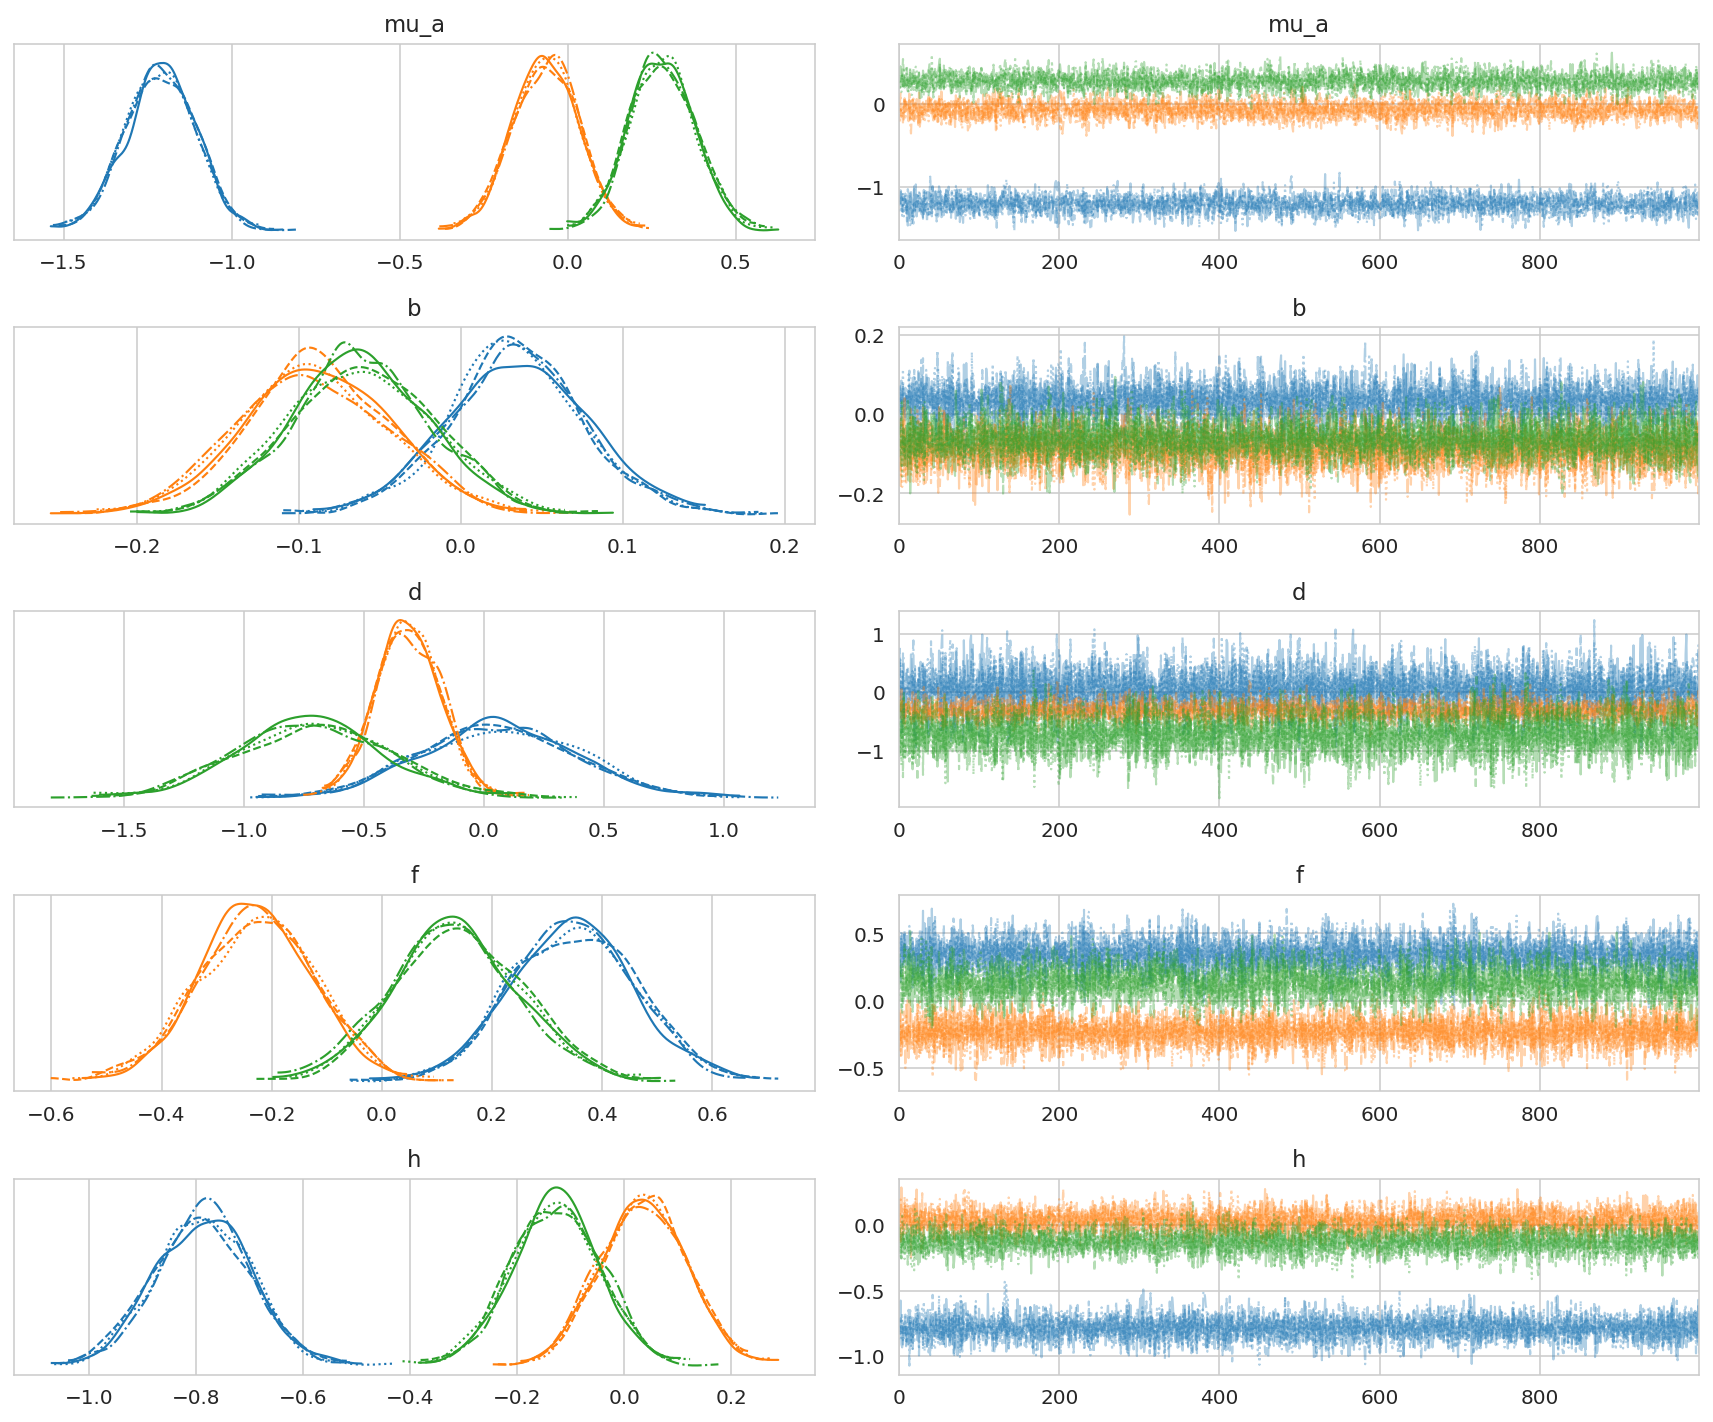

In [30]:
example_genes = ["KIF11", "AR", "NF2"]
az.plot_trace(
    trace,
    var_names=["mu_a", "b", "d", "f", "h"],
    coords={"gene": example_genes},
    compact=True,
)
plt.tight_layout()
plt.show()

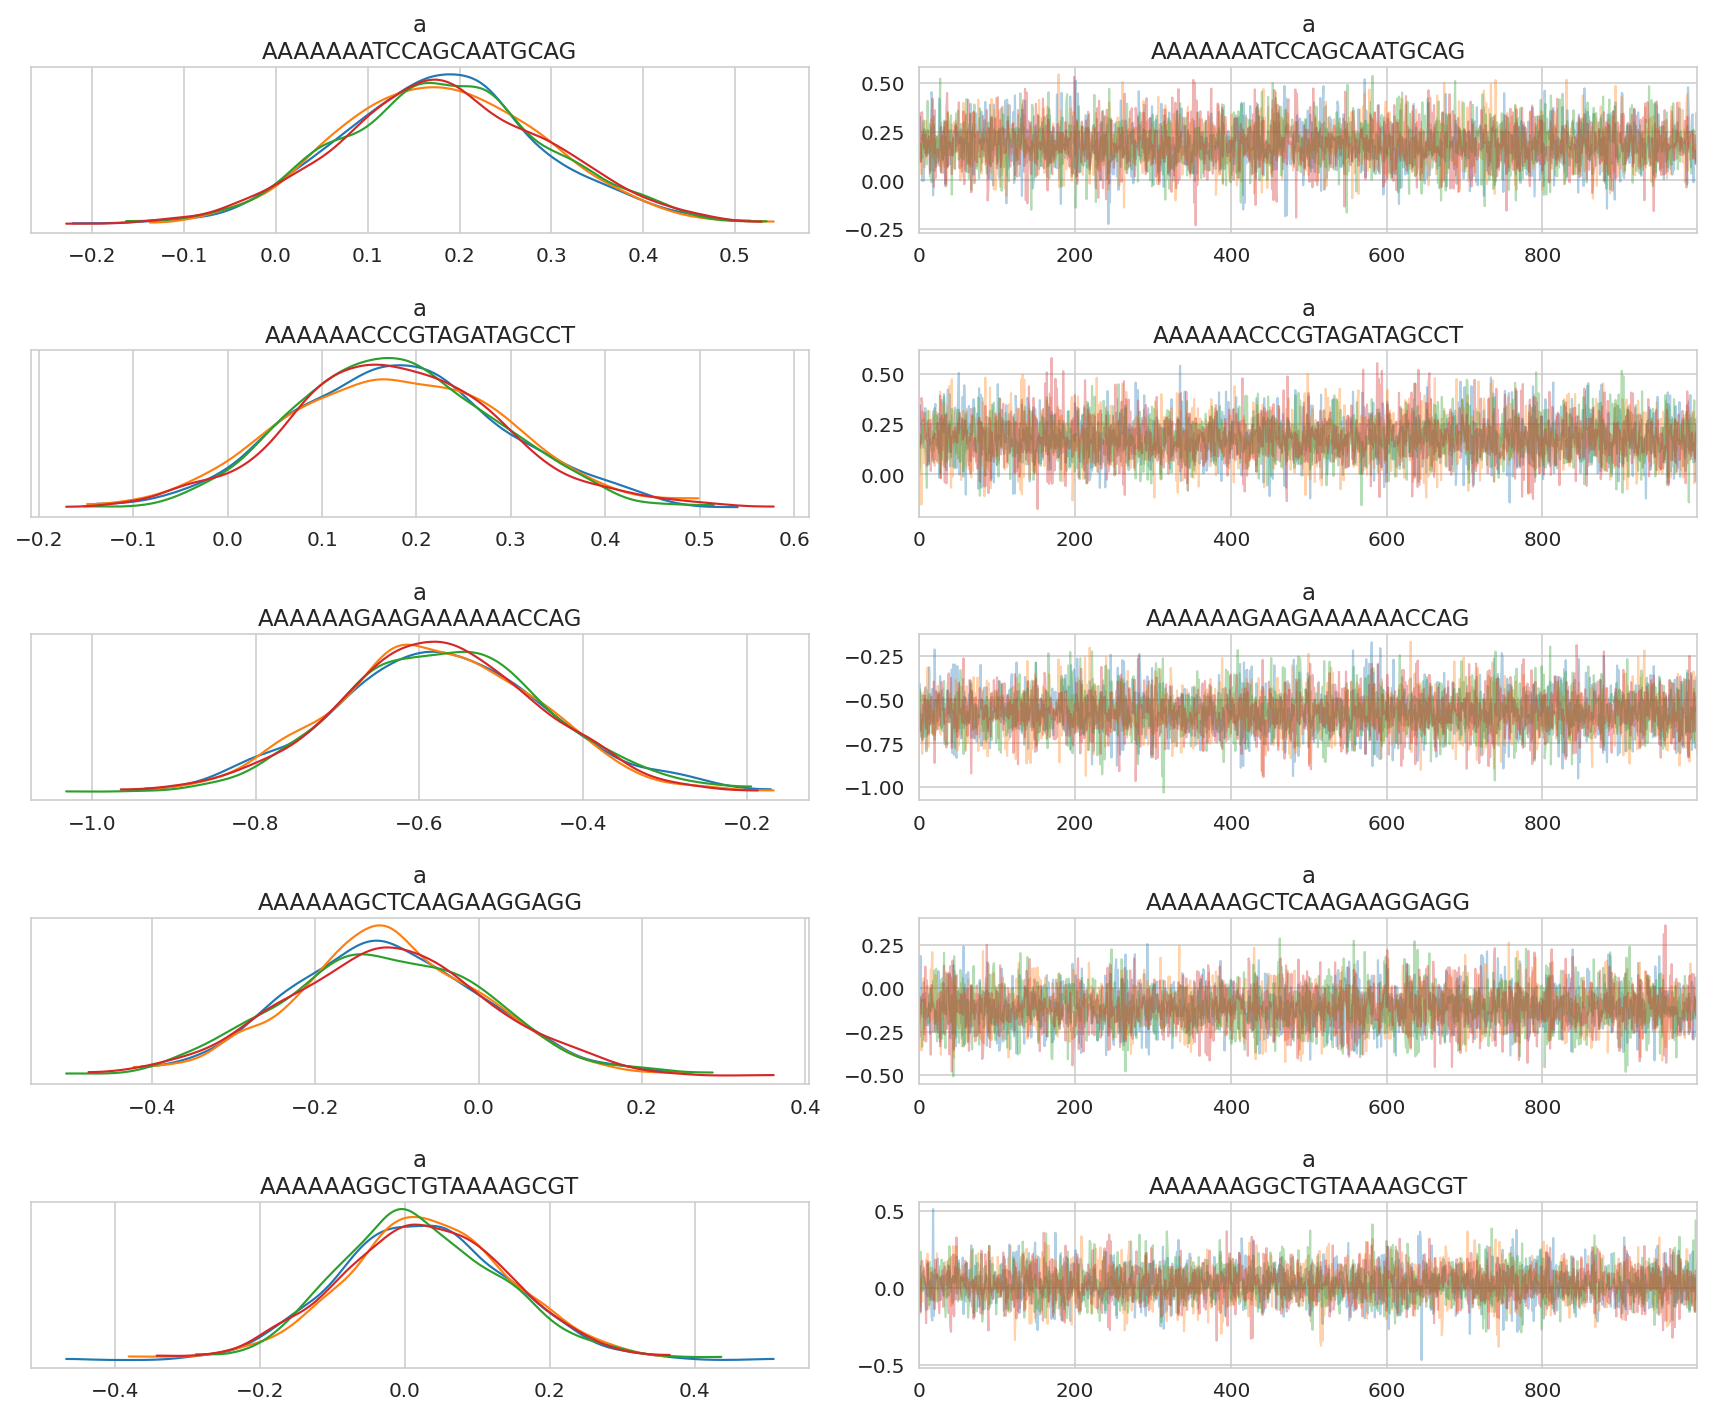

In [31]:
sgrnas_sample = trace.posterior.coords["sgrna"].values[:5]

az.plot_trace(trace, var_names="a", coords={"sgrna": sgrnas_sample}, compact=False)
plt.tight_layout()
plt.show()

In [32]:
cell_chromosome_map = (
    valid_prostate_data[["depmap_id", "sgrna_target_chr", "cell_chrom"]]
    .drop_duplicates()
    .sort_values("cell_chrom")
    .reset_index(drop=True)
)

In [33]:
chromosome_effect_post = (
    az.summary(trace, var_names=["k", "m"], kind="stats")
    .pipe(extract_coords_param_names, names="cell_chrom")
    .assign(var_name=lambda d: [p[0] for p in d.index.values])
    .merge(cell_chromosome_map, on="cell_chrom")
)

cell_effect_post = (
    az.summary(trace, var_names=["mu_k", "mu_m"], kind="stats")
    .pipe(extract_coords_param_names, names="depmap_id")
    .assign(var_name=lambda d: [p[:4] for p in d.index.values])
    .reset_index(drop=True)
    .pivot_wider(
        index="depmap_id",
        names_from="var_name",
        values_from=["mean", "hdi_5.5%", "hdi_94.5%"],
    )
)

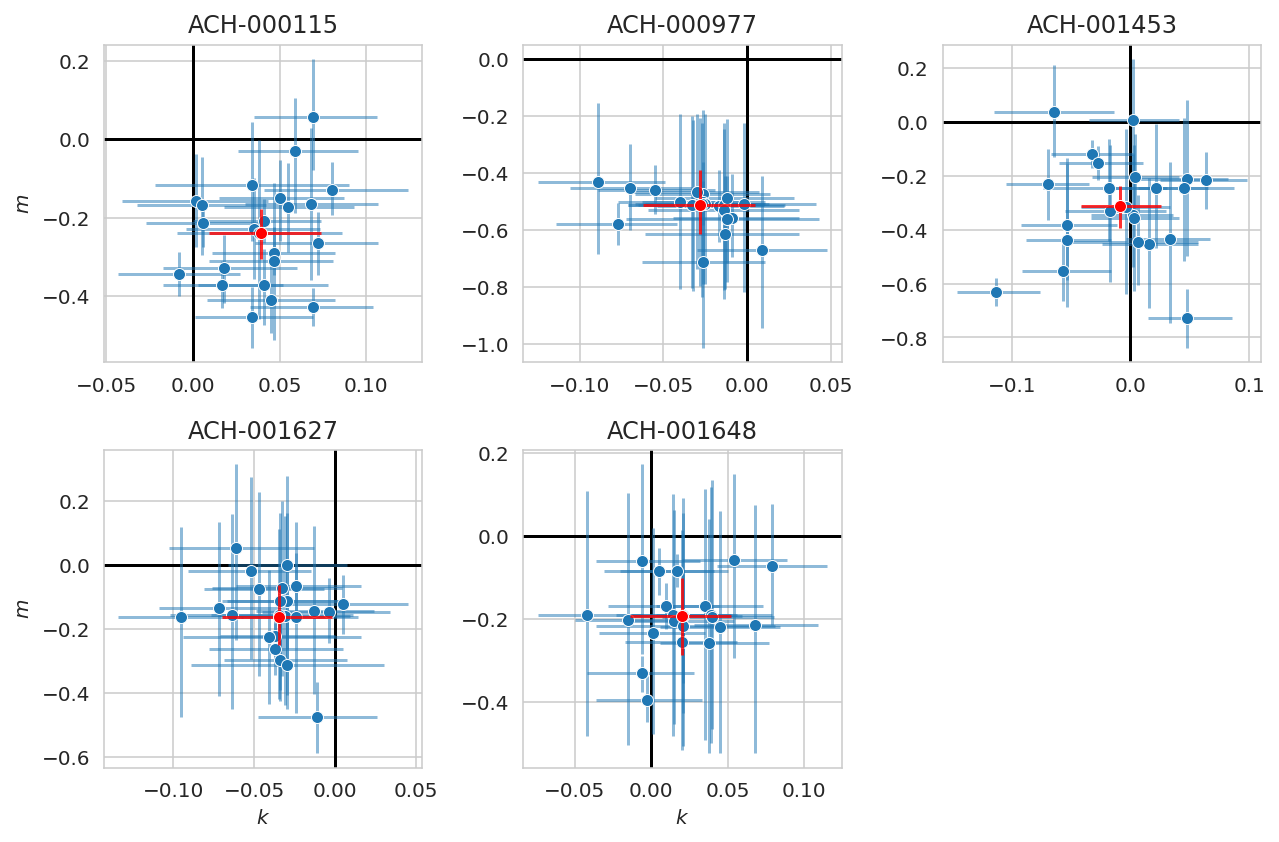

In [34]:
ncells = chromosome_effect_post["depmap_id"].nunique()
ncols = 3
nrows = ceil(ncells / 3)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(9, nrows * 3))
for ax, (cell, data_c) in zip(
    axes.flatten(), chromosome_effect_post.groupby("depmap_id")
):
    plot_df = data_c.pivot_wider(
        index="sgrna_target_chr",
        names_from="var_name",
        values_from=["mean", "hdi_5.5%", "hdi_94.5%"],
    )
    cell_eff = (
        cell_effect_post.copy().query(f"depmap_id == '{cell}'").reset_index(drop=True)
    )

    ax.axhline(0, color="k", zorder=1)
    ax.axvline(0, color="k", zorder=1)

    ax.vlines(
        x=plot_df["mean_k"],
        ymin=plot_df["hdi_5.5%_m"],
        ymax=plot_df["hdi_94.5%_m"],
        alpha=0.5,
        zorder=5,
    )
    ax.hlines(
        y=plot_df["mean_m"],
        xmin=plot_df["hdi_5.5%_k"],
        xmax=plot_df["hdi_94.5%_k"],
        alpha=0.5,
        zorder=5,
    )
    sns.scatterplot(data=plot_df, x="mean_k", y="mean_m", ax=ax, zorder=10)

    ax.vlines(
        x=cell_eff["mean_mu_k"],
        ymin=cell_eff["hdi_5.5%_mu_m"],
        ymax=cell_eff["hdi_94.5%_mu_m"],
        alpha=0.8,
        zorder=15,
        color="red",
    )
    ax.hlines(
        y=cell_eff["mean_mu_m"],
        xmin=cell_eff["hdi_5.5%_mu_k"],
        xmax=cell_eff["hdi_94.5%_mu_k"],
        alpha=0.8,
        zorder=15,
        color="red",
    )
    sns.scatterplot(
        data=cell_eff, x="mean_mu_k", y="mean_mu_m", ax=ax, zorder=20, color="red"
    )
    ax.set_title(cell)
    ax.set_xlabel(None)
    ax.set_ylabel(None)

for ax in axes[-1, :]:
    ax.set_xlabel("$k$")
for ax in axes[:, 0]:
    ax.set_ylabel("$m$")
for ax in axes.flatten()[ncells:]:
    ax.axis("off")

fig.tight_layout()
plt.show()

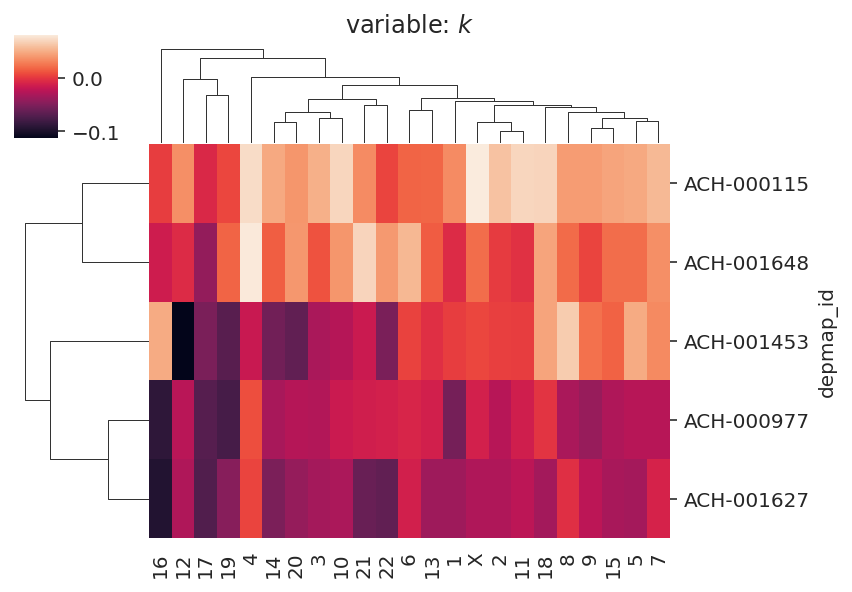

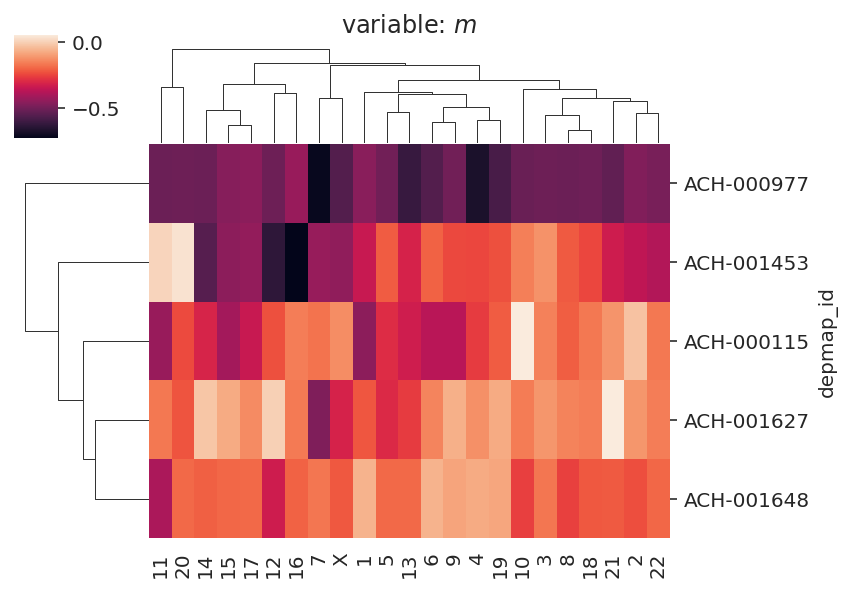

In [35]:
for v, data_v in chromosome_effect_post.groupby("var_name"):
    df = (
        data_v.copy()
        .reset_index(drop=True)
        .pivot_wider(
            index="depmap_id", names_from="sgrna_target_chr", values_from="mean"
        )
        .set_index("depmap_id")
    )
    cg = sns.clustermap(df, figsize=(6, 4))
    cg.ax_col_dendrogram.set_title(f"variable: ${v}$")
    plt.show()

In [36]:
genes_var_names = ["mu_a", "b", "d", "f"]
genes_var_names += [f"h[{g}]" for g in trace.posterior.coords["cancer_gene"].values]
gene_corr_post = (
    az.summary(trace, "genes_chol_cov_corr", kind="stats")
    .pipe(extract_coords_param_names, names=["d1", "d2"])
    .astype({"d1": int, "d2": int})
    .assign(
        p1=lambda d: [genes_var_names[i] for i in d["d1"]],
        p2=lambda d: [genes_var_names[i] for i in d["d2"]],
    )
    .assign(
        p1=lambda d: pd.Categorical(d["p1"], categories=d["p1"].unique(), ordered=True)
    )
    .assign(
        p2=lambda d: pd.Categorical(
            d["p2"], categories=d["p1"].cat.categories, ordered=True
        )
    )
)

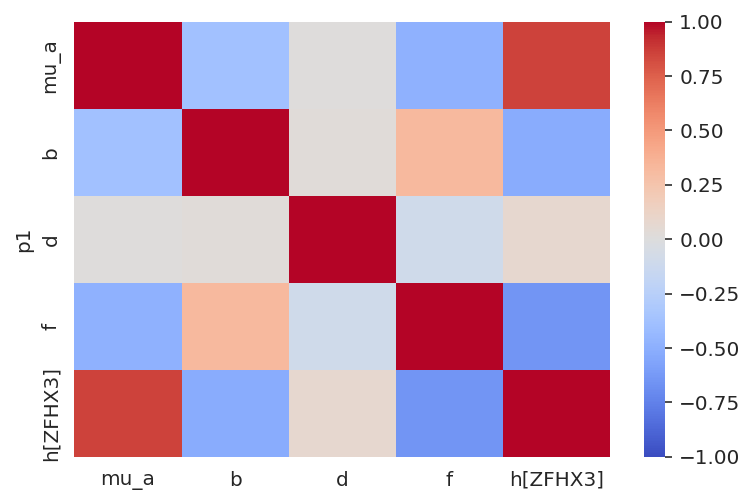

In [37]:
plot_df = gene_corr_post.pivot_wider("p1", "p2", "mean").set_index("p1")
sns.heatmap(plot_df, cmap="coolwarm", vmin=-1, vmax=1)
plt.show()

In [38]:
cancer_genes = trace.posterior.coords["cancer_gene"].values.tolist()
cancer_gene_mutants = (
    valid_prostate_data.filter_column_isin("hugo_symbol", cancer_genes)[
        ["hugo_symbol", "depmap_id", "is_mutated"]
    ]
    .drop_duplicates()
    .assign(is_mutated=lambda d: d["is_mutated"].map({True: "X", False: ""}))
    .pivot_wider("depmap_id", names_from="hugo_symbol", values_from="is_mutated")
    .set_index("depmap_id")
)
cancer_gene_mutants

ZFHX3
depmap_id       
ACH-000115      
ACH-000977     X
ACH-001453      
ACH-001627     X
ACH-001648

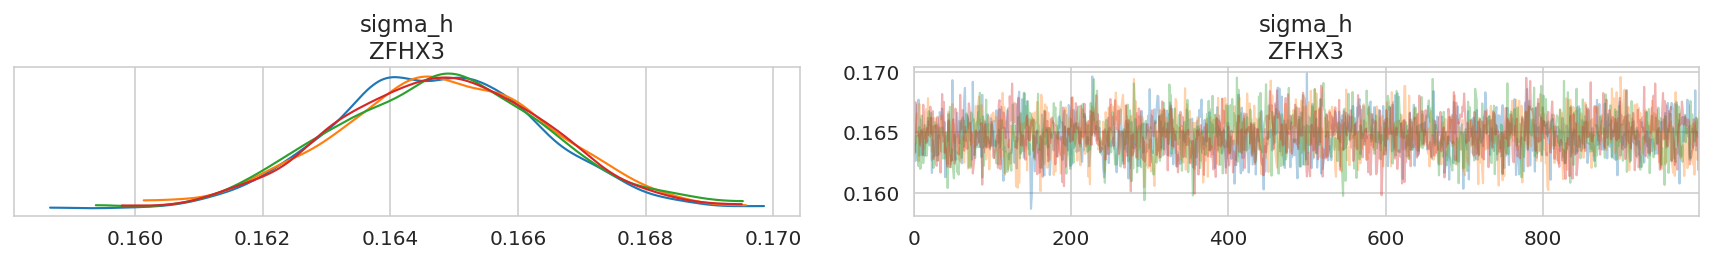

In [39]:
az.plot_trace(trace, var_names=["sigma_h"], compact=False)
plt.tight_layout()
plt.show()

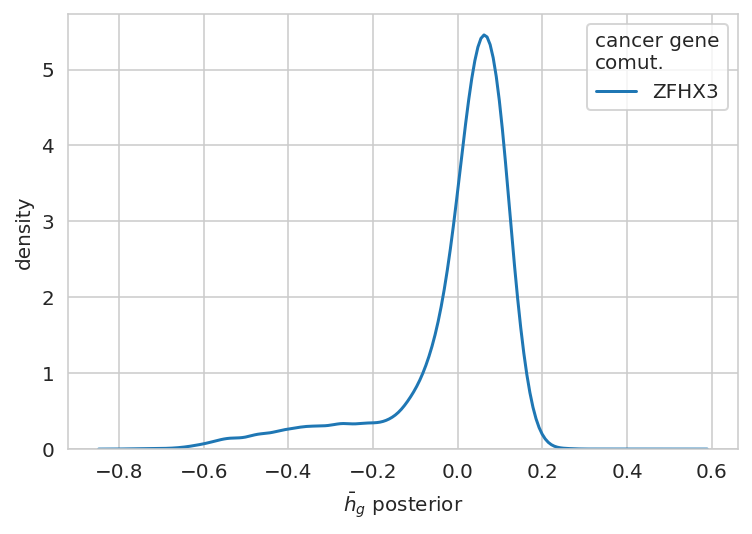

In [40]:
h_post_summary = (
    prostate_post_summary.query("var_name == 'h'")
    .reset_index(drop=True)
    .pipe(
        extract_coords_param_names,
        names=["hugo_symbol", "cancer_gene"],
        col="parameter",
    )
)

ax = sns.kdeplot(data=h_post_summary, x="mean", hue="cancer_gene")
ax.set_xlabel(r"$\bar{h}_g$ posterior")
ax.set_ylabel("density")
ax.get_legend().set_title("cancer gene\ncomut.")
plt.show()

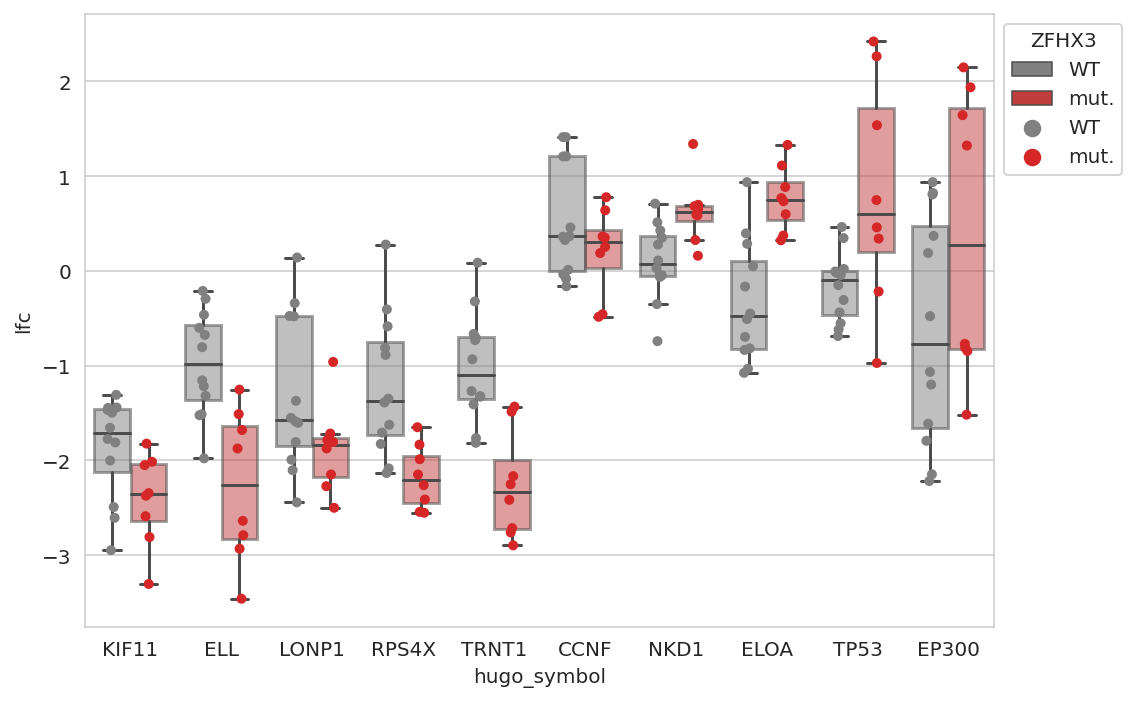

In [41]:
fig, axes = plt.subplots(
    len(cancer_genes), 1, squeeze=False, figsize=(8, len(cancer_genes) * 5)
)
for ax, cg in zip(axes.flatten(), cancer_genes):
    h_hits = (
        h_post_summary.filter_column_isin("cancer_gene", [cg])
        .sort_values("mean")
        .pipe(head_tail, n=5)["hugo_symbol"]
        .tolist()
    )

    h_hits_data = (
        valid_prostate_data.filter_column_isin("hugo_symbol", h_hits)
        .merge(cancer_gene_mutants.reset_index(), on="depmap_id")
        .reset_index()
        .astype({"hugo_symbol": str})
        .assign(
            hugo_symbol=lambda d: pd.Categorical(d["hugo_symbol"], categories=h_hits),
            _cg_mut=lambda d: d[cg].map({"X": "mut.", "": "WT"}),
        )
    )
    mut_pal = {"mut.": "tab:red", "WT": "gray"}
    sns.boxplot(
        data=h_hits_data,
        x="hugo_symbol",
        y="lfc",
        hue="_cg_mut",
        palette=mut_pal,
        ax=ax,
        showfliers=False,
        boxprops={"alpha": 0.5},
    )
    sns.stripplot(
        data=h_hits_data,
        x="hugo_symbol",
        y="lfc",
        hue="_cg_mut",
        dodge=True,
        palette=mut_pal,
        ax=ax,
    )
    sns.move_legend(ax, loc="upper left", bbox_to_anchor=(1, 1), title=cg)

plt.tight_layout()
plt.show()

---

## Session info

In [42]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 2.36 minutes


In [43]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-08-08

Python implementation: CPython
Python version       : 3.10.5
IPython version      : 8.4.0

Compiler    : GCC 10.3.0
OS          : Linux
Release     : 3.10.0-1160.45.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

Hostname: compute-a-16-170.o2.rc.hms.harvard.edu

Git branch: varying-chromosome

matplotlib: 3.5.2
pandas    : 1.4.3
numpy     : 1.23.1
seaborn   : 0.11.2
arviz     : 0.12.1

